In [1]:
import os
import sys
import inspect
from matplotlib import pyplot as plt
import numpy as np
import pickle

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:


# file = open("../parsed_data.pkl", 'rb')
# corrs = pickle.load(file)
# file.close()

file = open("../parsed_data_nm2_gender.pkl", 'rb')
pcorrs = pickle.load(file)
file.close()

In [3]:
pcorrs[0].keys()

dict_keys(['adjacency', 'gender'])

In [4]:
matricies = [np.array(pc['adjacency']).flatten() for pc in pcorrs]

In [5]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(matricies)

# Explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {np.sum(explained_var_ratio)*100}%" )


Explained Variance Ratio: 22.44221776100752%


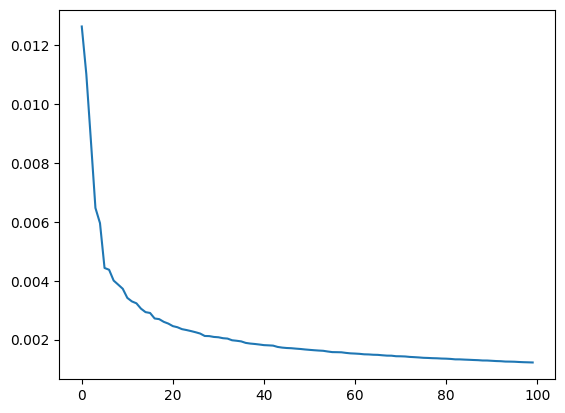

In [6]:
plt.plot(explained_var_ratio)

In [7]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(matricies)


In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
y =  [np.array(pc['gender']).flatten() for pc in pcorrs]
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'logloss'
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)


[14:43:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Accuracy: 0.8706467661691543
